# Installs & Imports

In [23]:
# Install necessary packages
def install_dependencies():
    """
    Install necessary packages for the multi-agent PPO workflow, including Optuna.
    """
    # Upgrade pip
    !pip install --upgrade pip -q

    # Install TorchRL, VMAS, and TensorDict
    !pip install torchrl --upgrade -q
    !pip install vmas --upgrade -q
    !pip install tensordict --upgrade -q

    # Install Optuna for hyperparameter tuning
    !pip install optuna --upgrade -q

    # Install additional libraries for visualization and progress bars
    !pip install matplotlib seaborn plotly --upgrade -q
    !pip install tqdm --upgrade -q
    !pip install pyvirtualdisplay --upgrade -q

    # Install system packages for rendering: Xvfb and OpenGL
    !apt-get update -qq
    !apt-get install -y -qq xvfb
    !apt-get install -y -qq python3-opengl

    print("All dependencies installed successfully.")

# Execute the installation function
install_dependencies()

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
All dependencies installed successfully.


In [2]:
import torch
from torch import multiprocessing
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from torch.nn import Sequential, Tanh
from tensordict.nn import TensorDictModule, TensorDictSequential
from tensordict.nn.distributions import NormalParamExtractor
from torchrl.modules import MultiAgentMLP, ProbabilisticActor, TanhNormal
from torchrl.collectors import SyncDataCollector
from torchrl.data.replay_buffers import ReplayBuffer
from torchrl.data.replay_buffers.samplers import SamplerWithoutReplacement
from torchrl.data.replay_buffers.storages import LazyTensorStorage
from torchrl.objectives import ClipPPOLoss, ValueEstimators
from torchrl.envs.transforms import RewardSum, TransformedEnv
from torchrl.envs.libs.vmas import VmasEnv
from torchrl.envs.utils import check_env_specs
from tqdm import tqdm
from PIL import Image
from IPython.display import Image as IPyImage, display
from pyvirtualdisplay import Display
import optuna
import os
import random
import copy

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

# Device & Hyperparameters

In [3]:
def configure_device_and_hyperparameters():
    """
    Configure the computation device and define base hyperparameters.
    """
    # Determine if multiprocessing uses 'fork'
    try:
        is_fork = multiprocessing.get_start_method(allow_none=True) == "fork"
    except RuntimeError:
        is_fork = False

    # Set device
    device = torch.device("cuda:0") if torch.cuda.is_available() and not is_fork else torch.device("cpu")
    vmas_device = device

    print(f"Computation Device: {device}")

    # Base Hyperparameters
    hyperparams = {
        # Sampling and training parameters
        'frames_per_batch': 6000,        # Number of frames collected per training iteration
        'n_iters': 10,                   # Number of training iterations
        'total_frames': 60000,           # Total frames to collect

        # Training specifics
        'num_epochs': 30,                # Number of optimization steps per iteration
        'minibatch_size': 400,           # Size of mini-batches
        'learning_rate': 3e-4,           # Learning rate
        'max_grad_norm': 1.0,            # Gradient clipping norm

        # PPO parameters
        'clip_epsilon': 0.2,             # Clipping value for PPO
        'gamma': 0.99,                   # Discount factor
        'lambda': 0.9,                   # GAE parameter
        'entropy_eps': 1e-4,             # Entropy coefficient

        # Environment parameters
        'max_steps': 100,                # Steps per episode
        'scenario_name': "navigation",   # VMAS scenario
        'n_agents': 3,                   # Number of agents per environment

        # Network parameters
        'depth': 2,                      # Depth of MLPs
        'num_cells': 256,                # Neurons per layer
        'activation': Tanh,              # Activation function
        'share_parameters_policy': True, # Share policy parameters
        'share_parameters_critic': True, # Share critic parameters
        'mappo': True,                   # Use MAPPO (centralized critic)
    }

    print("\nBase Hyperparameters defined:")
    for key, value in hyperparams.items():
        print(f"{key}: {value}")

    return device, vmas_device, hyperparams

# Execute the configuration function
device, vmas_device, hyperparams = configure_device_and_hyperparameters()

Computation Device: cuda:0

Base Hyperparameters defined:
frames_per_batch: 6000
n_iters: 10
total_frames: 60000
num_epochs: 30
minibatch_size: 400
learning_rate: 0.0003
max_grad_norm: 1.0
clip_epsilon: 0.2
gamma: 0.99
lambda: 0.9
entropy_eps: 0.0001
max_steps: 100
scenario_name: navigation
n_agents: 3
depth: 2
num_cells: 256
activation: <class 'torch.nn.modules.activation.Tanh'>
share_parameters_policy: True
share_parameters_critic: True
mappo: True


# Environment Setup

In [4]:
def setup_environment(hyperparams, device, vmas_device, seed=None):
    """
    Instantiate and configure the VMAS environment with necessary transforms and optional seeding.

    Args:
        hyperparams: The base hyperparameters dictionary.
        device: The computation device.
        vmas_device: The VMAS computation device.
        seed: (Optional) Random seed for reproducibility.

    Returns:
        env: Configured VMAS environment.
    """
    if seed is not None:
        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)

    print("\nInstantiating VMAS Environment...")

    # Calculate the number of vectorized environments
    num_vmas_envs = hyperparams['frames_per_batch'] // hyperparams['max_steps']

    # Instantiate the VMAS environment
    env = VmasEnv(
        scenario=hyperparams['scenario_name'],
        num_envs=num_vmas_envs,
        continuous_actions=True,          # VMAS supports both continuous and discrete actions
        max_steps=hyperparams['max_steps'],
        device=vmas_device,
        n_agents=hyperparams['n_agents'], # Number of agents
    )

    print("Environment Configuration:")
    print(env)

    # Apply RewardSum transform to sum rewards per episode
    env = TransformedEnv(
        env,
        RewardSum(
            in_keys=[env.reward_key],
            out_keys=[("agents", "episode_reward")],
        ),
    )

    # Verify environment specifications
    try:
        check_env_specs(env)
        print("\nEnvironment specifications are correct.")
    except Exception as e:
        print("\nEnvironment specification check failed:")
        print(e)

    # Inspect environment specs
    print("\nEnvironment Specs:")
    print("Action Spec:", env.full_action_spec)
    print("Reward Spec:", env.full_reward_spec)
    print("Done Spec:", env.full_done_spec)
    print("Observation Spec:", env.observation_spec)

    # Inspect action, reward, and done keys
    print("\nAction Keys:", env.action_keys)
    print("Reward Keys:", env.reward_keys)
    print("Done Keys:", env.done_keys)

    # Example rollout
    n_rollout_steps = 5
    rollout = env.rollout(n_rollout_steps)
    print("\nSample Rollout:")
    print(rollout)
    print("Shape of the rollout TensorDict:", rollout.batch_size)

    return env

# Execute the environment setup function
env = setup_environment(hyperparams, device, vmas_device)


Instantiating VMAS Environment...


2024-11-01 05:38:07,879 [torchrl][INFO] check_env_specs succeeded!


Environment Configuration:
VmasEnv(num_envs=60, n_agents=3, batch_size=torch.Size([60]), device=cuda:0) (scenario=navigation)

Environment specifications are correct.

Environment Specs:
Action Spec: Composite(
    agents: Composite(
        action: BoundedContinuous(
            shape=torch.Size([60, 3, 2]),
            space=ContinuousBox(
                low=Tensor(shape=torch.Size([60, 3, 2]), device=cuda:0, dtype=torch.float32, contiguous=True),
                high=Tensor(shape=torch.Size([60, 3, 2]), device=cuda:0, dtype=torch.float32, contiguous=True)),
            device=cuda:0,
            dtype=torch.float32,
            domain=continuous),
        device=cuda:0,
        shape=torch.Size([60, 3])),
    device=cuda:0,
    shape=torch.Size([60]))
Reward Spec: Composite(
    agents: Composite(
        reward: UnboundedContinuous(
            shape=torch.Size([60, 3, 1]),
            space=ContinuousBox(
                low=Tensor(shape=torch.Size([60, 3, 1]), device=cuda:0, dty

# Policy & Critic Networks

In [5]:
def define_policy_network(env, hyperparams, device):
    """
    Define and initialize the policy network.

    Args:
        env: The VMAS environment.
        hyperparams: The hyperparameters dictionary.
        device: The computation device.

    Returns:
        policy: The ProbabilisticActor representing the policy network.
    """
    print("\nDefining Policy Network...")

    # Define the policy network
    policy_net = Sequential(
        MultiAgentMLP(
            n_agent_inputs=env.observation_spec["agents", "observation"].shape[-1],  # Number of observations per agent
            n_agent_outputs=2 * env.full_action_spec["agents", "action"].shape[-1],  # 2 * actions per agent (mean and std)
            n_agents=env.n_agents,
            centralised=False,  # Decentralized policies
            share_params=hyperparams['share_parameters_policy'],
            device=device,
            depth=hyperparams['depth'],
            num_cells=hyperparams['num_cells'],
            activation_class=hyperparams['activation'],
        ),
        NormalParamExtractor(),  # Separates outputs into mean and std
    )

    # Wrap the policy network in a TensorDictModule
    policy_module = TensorDictModule(
        policy_net,
        in_keys=[("agents", "observation")],
        out_keys=[("agents", "loc"), ("agents", "scale")],
    )

    # Define the ProbabilisticActor
    policy = ProbabilisticActor(
        module=policy_module,
        spec=env.full_action_spec,  # Using full (batched) action spec
        in_keys=[("agents", "loc"), ("agents", "scale")],
        out_keys=[env.action_key],
        distribution_class=TanhNormal,
        distribution_kwargs={
            "low": env.full_action_spec[env.action_key].space.low,
            "high": env.full_action_spec[env.action_key].space.high,
        },
        return_log_prob=True,
        log_prob_key=("agents", "sample_log_prob"),
    )

    print("Policy Network Defined Successfully.")
    print("Sample Policy Output:")
    sample_reset = env.reset()
    policy_output = policy(sample_reset)
    print(policy_output)

    return policy

def define_critic_network(env, hyperparams, device):
    """
    Define and initialize the critic network.

    Args:
        env: The VMAS environment.
        hyperparams: The hyperparameters dictionary.
        device: The computation device.

    Returns:
        critic: The TensorDictModule representing the critic network.
    """
    print("\nDefining Critic Network...")

    # Define the critic network
    critic_net = MultiAgentMLP(
        n_agent_inputs=env.observation_spec["agents", "observation"].shape[-1],
        n_agent_outputs=1,  # 1 value per agent
        n_agents=env.n_agents,
        centralised=hyperparams['mappo'],    # Centralized if MAPPO
        share_params=hyperparams['share_parameters_critic'],
        device=device,
        depth=hyperparams['depth'],
        num_cells=hyperparams['num_cells'],
        activation_class=hyperparams['activation'],
    )

    # Wrap the critic network in a TensorDictModule
    critic = TensorDictModule(
        module=critic_net,
        in_keys=[("agents", "observation")],
        out_keys=[("agents", "state_value")],
    )

    print("Critic Network Defined Successfully.")
    print("Sample Critic Output:")
    sample_reset = env.reset()
    critic_output = critic(sample_reset)
    print(critic_output)

    return critic

# Define and execute the policy and critic networks
policy = define_policy_network(env, hyperparams, device)
critic = define_critic_network(env, hyperparams, device)


Defining Policy Network...
Policy Network Defined Successfully.
Sample Policy Output:
TensorDict(
    fields={
        agents: TensorDict(
            fields={
                action: Tensor(shape=torch.Size([60, 3, 2]), device=cuda:0, dtype=torch.float32, is_shared=True),
                episode_reward: Tensor(shape=torch.Size([60, 3, 1]), device=cuda:0, dtype=torch.float32, is_shared=True),
                info: TensorDict(
                    fields={
                        agent_collisions: Tensor(shape=torch.Size([60, 3, 1]), device=cuda:0, dtype=torch.float32, is_shared=True),
                        final_rew: Tensor(shape=torch.Size([60, 3, 1]), device=cuda:0, dtype=torch.float32, is_shared=True),
                        pos_rew: Tensor(shape=torch.Size([60, 3, 1]), device=cuda:0, dtype=torch.float32, is_shared=True)},
                    batch_size=torch.Size([60, 3]),
                    device=cuda:0,
                    is_shared=True),
                loc: Tensor(shape=t

# Collector & Replay Buffer

In [6]:
def setup_collector_and_replay_buffer(env, policy, hyperparams, device, vmas_device):
    """
    Create and initialize the data collector and replay buffer.

    Args:
        env: The VMAS environment.
        policy: The policy network.
        hyperparams: The hyperparameters dictionary.
        device: The computation device.
        vmas_device: The VMAS computation device.

    Returns:
        collector: The SyncDataCollector instance.
        replay_buffer: The ReplayBuffer instance.
    """
    print("\nSetting Up Data Collector...")

    # Initialize the data collector
    collector = SyncDataCollector(
        env,
        policy,
        device=vmas_device,
        storing_device=device,
        frames_per_batch=hyperparams['frames_per_batch'],
        total_frames=hyperparams['total_frames'],
    )

    print("Data Collector Initialized Successfully.")
    print(collector)

    print("\nSetting Up Replay Buffer...")

    # Initialize the replay buffer
    replay_buffer = ReplayBuffer(
        storage=LazyTensorStorage(
            max_size=hyperparams['frames_per_batch'],  # Storage size matches frames_per_batch
            device=device,
        ),
        sampler=SamplerWithoutReplacement(),
        batch_size=hyperparams['minibatch_size'],  # Mini-batch size for sampling
    )

    print("Replay Buffer Initialized Successfully.")
    print(replay_buffer)

    return collector, replay_buffer

# Setup collector and replay buffer
collector, replay_buffer = setup_collector_and_replay_buffer(env, policy, hyperparams, device, vmas_device)


Setting Up Data Collector...
Data Collector Initialized Successfully.
SyncDataCollector(
    env=TransformedEnv(
        env=VmasEnv(num_envs=60, n_agents=3, batch_size=torch.Size([60]), device=cuda:0) (scenario=navigation),
        transform=RewardSum(keys=[('agents', 'reward')])),
    policy=ProbabilisticActor(
        module=ModuleList(
          (0): TensorDictModule(
              module=Sequential(
                (0): MultiAgentMLP(
                    MLP(
                      (0): Linear(in_features=18, out_features=256, bias=True)
                      (1): Tanh()
                      (2): Linear(in_features=256, out_features=256, bias=True)
                      (3): Tanh()
                      (4): Linear(in_features=256, out_features=4, bias=True)
                    ),
                    n_agents=3,
                    share_params=True,
                    centralized=False,
                    agent_dim=-2)
                (1): NormalParamExtractor(
               

# Loss & Optimizer

In [7]:
def setup_optimizer(loss_module, hyperparams):
    """
    Initialize the optimizer.

    Args:
        loss_module: The PPO loss module.
        hyperparams: The hyperparameters dictionary.

    Returns:
        optim: The optimizer.
    """
    print("\nSetting Up Optimizer...")

    # Initialize the optimizer
    optim = torch.optim.Adam(loss_module.parameters(), hyperparams['learning_rate'])

    print("Optimizer Initialized Successfully.")
    print(optim)

    return optim

def setup_loss_function(env, critic, hyperparams, policy):
    """
    Initialize the PPO loss function and the optimizer.

    Args:
        env: The VMAS environment.
        critic: The critic network.
        hyperparams: The hyperparameters dictionary.
        policy: The policy network.

    Returns:
        loss_module: The PPO loss module.
        optim: The optimizer.
    """
    print("\nSetting Up PPO Loss Function...")

    # Initialize the PPO loss function
    loss_module = ClipPPOLoss(
        actor_network=policy,
        critic_network=critic,
        clip_epsilon=hyperparams['clip_epsilon'],
        entropy_bonus=hyperparams['entropy_eps'],
        value_loss_coef=0.5,
        normalize_advantage=False,  # Important to avoid normalizing across the agent dimension
    )

    # Set the keys where the loss module will find necessary data
    loss_module.set_keys(
        reward=env.reward_key,
        action=env.action_key,
        sample_log_prob=("agents", "sample_log_prob"),
        value=("agents", "state_value"),
        done=("agents", "done"),
        terminated=("agents", "terminated"),
    )

    # Configure the advantage estimator (GAE)
    loss_module.make_value_estimator(
        ValueEstimators.GAE,
        gamma=hyperparams['gamma'],
        lmbda=hyperparams['lambda']
    )

    print("PPO Loss Module Initialized Successfully.")
    print(loss_module)

    # Setup optimizer
    optim = setup_optimizer(loss_module, hyperparams)

    return loss_module, optim

# Setup loss function and optimizer
loss_module, optim = setup_loss_function(env, critic, hyperparams, policy)


Setting Up PPO Loss Function...
PPO Loss Module Initialized Successfully.
ClipPPOLoss()

Setting Up Optimizer...
Optimizer Initialized Successfully.
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0003
    maximize: False
    weight_decay: 0
)


# Training Loop Run

In [8]:
def training_loop(collector, replay_buffer, loss_module, optim, hyperparams):
    """
    Execute the training loop for the multi-agent PPO.

    Args:
        collector: The SyncDataCollector instance.
        replay_buffer: The ReplayBuffer instance.
        loss_module: The PPO loss module.
        optim: The optimizer.
        hyperparams: The hyperparameters dictionary.

    Returns:
        episode_reward_mean_list: List of mean episode rewards per training iteration.
    """
    print("\nStarting Training Loop...")

    # Initialize progress bar
    pbar = tqdm(total=hyperparams['n_iters'], desc="episode_reward_mean = 0")

    # Initialize list to store training metrics
    episode_reward_mean_list = []

    for iteration, tensordict_data in enumerate(collector, 1):
        print(f"\n--- Training Iteration {iteration} ---")

        # Expand 'done' and 'terminated' to match the reward shape
        try:
            tensordict_data.set(
                ("next", "agents", "done"),
                tensordict_data.get(("next", "done"))
                .unsqueeze(-1)
                .expand(tensordict_data.get_item_shape(("next", "agents", "episode_reward"))),
            )
            tensordict_data.set(
                ("next", "agents", "terminated"),
                tensordict_data.get(("next", "terminated"))
                .unsqueeze(-1)
                .expand(tensordict_data.get_item_shape(("next", "agents", "episode_reward"))),
            )
        except KeyError as e:
            print(f"KeyError during expansion: {e}. Skipping this batch.")
            continue

        # Compute Generalized Advantage Estimation (GAE)
        with torch.no_grad():
            loss_module.value_estimator(tensordict_data)

        # Flatten the batch size for replay buffer
        data_view = tensordict_data.reshape(-1)
        replay_buffer.extend(data_view)
        print("Data added to Replay Buffer.")

        # Perform training epochs
        for epoch in range(hyperparams['num_epochs']):
            for _ in range(hyperparams['frames_per_batch'] // hyperparams['minibatch_size']):
                # Sample a mini-batch from the replay buffer
                subdata = replay_buffer.sample()

                # Compute PPO loss
                loss_vals = loss_module(subdata)

                # Total loss is the sum of policy, value, and entropy losses
                loss_value = (
                    loss_vals["loss_objective"]
                    + loss_vals["loss_critic"]
                    + loss_vals["loss_entropy"]
                )

                # Backpropagation
                loss_value.backward()

                # Gradient clipping
                torch.nn.utils.clip_grad_norm_(
                    loss_module.parameters(), hyperparams['max_grad_norm']
                )

                # Optimizer step
                optim.step()
                optim.zero_grad()

        # Update policy weights in the collector
        collector.update_policy_weights_()
        print("Policy weights updated.")

        # Logging: Compute the mean reward for the current batch
        try:
            done = tensordict_data.get(("next", "agents", "done"))
            episode_reward_mean = (
                tensordict_data.get(("next", "agents", "episode_reward"))[done].mean().item()
            )
            episode_reward_mean_list.append(episode_reward_mean)
            print(f"Mean Episode Reward: {episode_reward_mean}")
        except Exception as e:
            print(f"Error during logging: {e}. Setting episode_reward_mean to 0.")
            episode_reward_mean = 0.0
            episode_reward_mean_list.append(episode_reward_mean)

        # Update progress bar with the latest mean reward
        pbar.set_description(f"episode_reward_mean = {episode_reward_mean:.2f}", refresh=False)
        pbar.update()

        # Break the loop after the desired number of iterations
        if iteration >= hyperparams['n_iters']:
            break

    pbar.close()

    return episode_reward_mean_list

# Execute the training loop
episode_reward_mean_list = training_loop(collector, replay_buffer, loss_module, optim, hyperparams)


Starting Training Loop...


episode_reward_mean = 0:   0%|          | 0/10 [00:00<?, ?it/s]


--- Training Iteration 1 ---
Data added to Replay Buffer.


episode_reward_mean = -1.24:  10%|█         | 1/10 [00:06<00:55,  6.12s/it]

Policy weights updated.
Mean Episode Reward: -1.2406542301177979

--- Training Iteration 2 ---
Data added to Replay Buffer.


episode_reward_mean = -0.04:  20%|██        | 2/10 [00:11<00:45,  5.68s/it]

Policy weights updated.
Mean Episode Reward: -0.039041921496391296

--- Training Iteration 3 ---
Data added to Replay Buffer.


episode_reward_mean = 1.01:  30%|███       | 3/10 [00:16<00:38,  5.44s/it] 

Policy weights updated.
Mean Episode Reward: 1.0079302787780762

--- Training Iteration 4 ---
Data added to Replay Buffer.


episode_reward_mean = 1.35:  40%|████      | 4/10 [00:21<00:31,  5.29s/it]

Policy weights updated.
Mean Episode Reward: 1.3487430810928345

--- Training Iteration 5 ---
Data added to Replay Buffer.


episode_reward_mean = 1.91:  50%|█████     | 5/10 [00:26<00:26,  5.25s/it]

Policy weights updated.
Mean Episode Reward: 1.9095832109451294

--- Training Iteration 6 ---
Data added to Replay Buffer.


episode_reward_mean = 2.16:  60%|██████    | 6/10 [00:31<00:20,  5.17s/it]

Policy weights updated.
Mean Episode Reward: 2.1639533042907715

--- Training Iteration 7 ---
Data added to Replay Buffer.


episode_reward_mean = 2.26:  70%|███████   | 7/10 [00:37<00:15,  5.17s/it]

Policy weights updated.
Mean Episode Reward: 2.2599756717681885

--- Training Iteration 8 ---
Data added to Replay Buffer.


episode_reward_mean = 2.61:  80%|████████  | 8/10 [00:42<00:10,  5.14s/it]

Policy weights updated.
Mean Episode Reward: 2.6148793697357178

--- Training Iteration 9 ---
Data added to Replay Buffer.


episode_reward_mean = 2.44:  90%|█████████ | 9/10 [00:47<00:05,  5.19s/it]

Policy weights updated.
Mean Episode Reward: 2.4376578330993652

--- Training Iteration 10 ---
Data added to Replay Buffer.


episode_reward_mean = 2.71: 100%|██████████| 10/10 [00:52<00:00,  5.27s/it]

Policy weights updated.
Mean Episode Reward: 2.7070767879486084


# Evaluation & Rendering

Plotting Training Results...


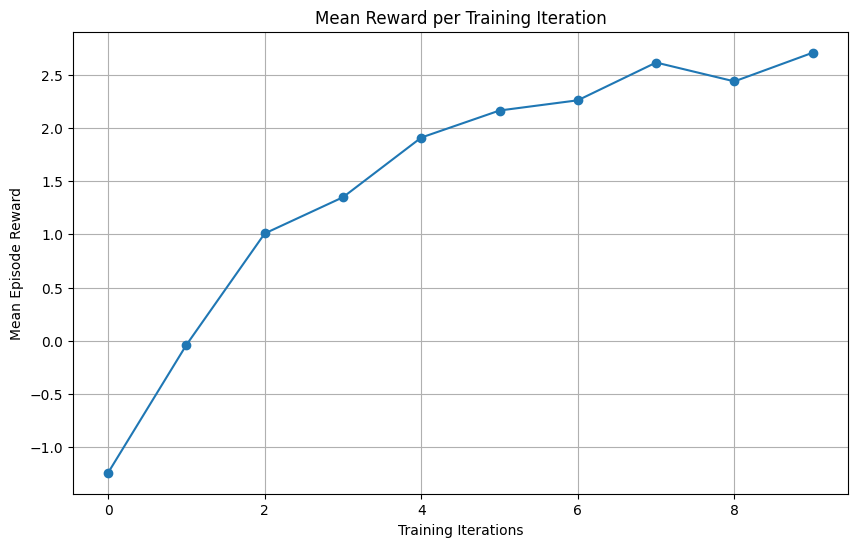

Training evaluation completed.


In [9]:
def evaluate_and_visualize(episode_reward_mean_list, hyperparams):
    """
    Plot the mean reward obtained per episode.
    """
    print("Plotting Training Results...")

    plt.figure(figsize=(10, 6))
    plt.plot(episode_reward_mean_list, marker='o', linestyle='-')
    plt.xlabel("Training Iterations")
    plt.ylabel("Mean Episode Reward")
    plt.title("Mean Reward per Training Iteration")
    plt.grid(True)
    plt.show()

    print("Training evaluation completed.")

# Execute the evaluation and visualization function
evaluate_and_visualize(episode_reward_mean_list, hyperparams)

Setting Up Virtual Display for Rendering...
Virtual Display Started Successfully.

Starting Rendering of the Trained Policy...
Number of frames captured: 99
Rendering Completed. GIF saved as navigation.gif.
Displaying the Rendered GIF...


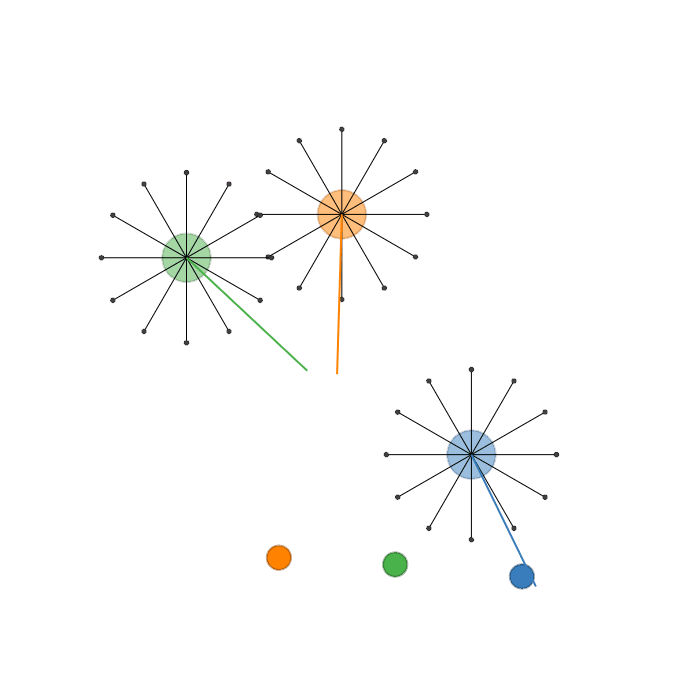

In [10]:
def setup_virtual_display():
    """
    Set up a virtual display for rendering in headless environments like Colab.
    """
    print("Setting Up Virtual Display for Rendering...")
    try:
        display = Display(visible=False, size=(1400, 900))
        display.start()
        print("Virtual Display Started Successfully.")
        return display
    except Exception as e:
        print(f"Error setting up virtual display: {e}")
        return None

def render_policy(env, policy, hyperparams):
    """
    Render the trained policy by capturing frames and creating a GIF.
    """
    print("\nStarting Rendering of the Trained Policy...")

    # Initialize frames list
    env.frames = []

    # Define a callback to capture frames
    def rendering_callback(env, td):
        try:
            frame = env.render(mode="rgb_array")
            env.frames.append(Image.fromarray(frame))
        except Exception as e:
            print(f"Error during rendering callback: {e}")

    # Perform rollout with rendering
    with torch.no_grad():
        try:
            env.rollout(
                max_steps=hyperparams['max_steps'],
                policy=policy,
                callback=rendering_callback,
                auto_cast_to_device=True,
                break_when_any_done=False,
            )
        except Exception as e:
            print(f"Error during rollout: {e}")
            return

    if len(env.frames) == 0:
        print("No frames captured. Rendering failed.")
        return

    # Save the captured frames as a GIF
    print(f"Number of frames captured: {len(env.frames)}")
    gif_filename = f"{hyperparams['scenario_name']}.gif"
    try:
        env.frames[0].save(
            gif_filename,
            save_all=True,
            append_images=env.frames[1:],
            duration=1000,
            loop=0,
        )
        print(f"Rendering Completed. GIF saved as {gif_filename}.")
    except Exception as e:
        print(f"Error saving GIF: {e}")
        return

    # Display the GIF
    display_gif(gif_filename, env)

def display_gif(gif_filename, env):
    """
    Display the saved GIF within the notebook.
    """
    print("Displaying the Rendered GIF...")
    try:
        # Use IPython.display.display to render the image
        display(IPyImage(filename=gif_filename))
    except Exception as e:
        print(f"Error displaying GIF: {e}")

# Execute the rendering setup and rendering functions
virtual_display = setup_virtual_display()
render_policy(env, policy, hyperparams)

In [13]:
def save_policy(policy, critic, save_dir="saved_policies", trial=1):
    """
    Save the policy and critic state dictionaries.

    Args:
        policy: The policy network.
        critic: The critic network.
        save_dir: Directory where the models will be saved.
        trial: Trial number or identifier.
    """
    os.makedirs(save_dir, exist_ok=True)

    policy_path = os.path.join(save_dir, f"policy_trial_{trial}.pth")
    critic_path = os.path.join(save_dir, f"critic_trial_{trial}.pth")

    torch.save(policy.state_dict(), policy_path)
    torch.save(critic.state_dict(), critic_path)

    print(f"Policy saved to {policy_path}")
    print(f"Critic saved to {critic_path}")

def load_policy(policy, critic, save_dir="saved_policies", trial=1):
    """
    Load the policy and critic state dictionaries.

    Args:
        policy: The policy network.
        critic: The critic network.
        save_dir: Directory where the models are saved.
        trial: Trial number or identifier.
    """
    policy_path = os.path.join(save_dir, f"policy_trial_{trial}.pth")
    critic_path = os.path.join(save_dir, f"critic_trial_{trial}.pth")

    if os.path.exists(policy_path) and os.path.exists(critic_path):
        policy.load_state_dict(torch.load(policy_path, map_location=device))
        critic.load_state_dict(torch.load(critic_path, map_location=device))
        print(f"Policy loaded from {policy_path}")
        print(f"Critic loaded from {critic_path}")
    else:
        print("Saved models not found. Please check the save directory and trial number.")

# Save the trained policy and critic
save_policy(policy, critic, save_dir="saved_policies", trial=1)

# Load the trained policy and critic
load_policy(policy, critic, save_dir="saved_policies", trial=1)

Policy saved to saved_policies/policy_trial_1.pth
Critic saved to saved_policies/critic_trial_1.pth
Policy loaded from saved_policies/policy_trial_1.pth
Critic loaded from saved_policies/critic_trial_1.pth


In [12]:
# Check files
print("Files in the current directory:", os.listdir('.'))

Files in the current directory: ['.config', 'navigation.gif', 'saved_policies', 'sample_data']


# Hyperparameter Tuning

In [14]:
def objective(trial, env_creator, base_hyperparams, device, vmas_device, save_dir="optuna_best_model"):
    """
    Objective function for Optuna hyperparameter tuning.

    Args:
        trial: Optuna trial object.
        env_creator: Function to create the environment.
        base_hyperparams: Dictionary of base hyperparameters.
        device: Computation device.
        vmas_device: VMAS computation device.
        save_dir: Directory to save the best model.

    Returns:
        final_mean_reward: The final mean episode reward after training.
    """
    # 1. Sample hyperparameters
    trial_hyperparams = copy.deepcopy(base_hyperparams)
    trial_hyperparams['learning_rate'] = trial.suggest_float('learning_rate', 1e-5, 1e-3, log=True)
    trial_hyperparams['clip_epsilon'] = trial.suggest_float('clip_epsilon', 0.1, 0.3)
    trial_hyperparams['gamma'] = trial.suggest_float('gamma', 0.95, 0.99)
    trial_hyperparams['lambda'] = trial.suggest_float('lambda', 0.8, 0.95)
    trial_hyperparams['num_epochs'] = trial.suggest_categorical('num_epochs', [20, 30, 40])
    trial_hyperparams['minibatch_size'] = trial.suggest_categorical('minibatch_size', [400, 600, 800])

    print(f"\n--- Trial {trial.number + 1} ---")
    print("Sampled Hyperparameters:")
    for key, value in trial_hyperparams.items():
        print(f"  {key}: {value}")

    # 2. Set up environment and networks
    trial_env = env_creator(trial_hyperparams, device, vmas_device, seed=trial.number)
    trial_policy = define_policy_network(trial_env, trial_hyperparams, device)
    trial_critic = define_critic_network(trial_env, trial_hyperparams, device)
    trial_collector, trial_replay_buffer = setup_collector_and_replay_buffer(
        trial_env, trial_policy, trial_hyperparams, device, vmas_device
    )
    trial_loss_module, trial_optim = setup_loss_function(trial_env, trial_critic, trial_hyperparams, trial_policy)

    # 3. Train the model
    trial_episode_rewards = training_loop(
        trial_collector, trial_replay_buffer, trial_loss_module, trial_optim, trial_hyperparams
    )

    # 4. Evaluate performance
    final_mean_reward = trial_episode_rewards[-1] if trial_episode_rewards else None
    print(f"Trial {trial.number + 1} Final Mean Reward: {final_mean_reward}")

    # 5. Save best model
    if final_mean_reward is not None:
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        if not hasattr(objective, 'best_reward') or final_mean_reward > objective.best_reward:
            objective.best_reward = final_mean_reward
            model_path = os.path.join(save_dir, f"best_trial_{trial.number + 1}.pth")
            critic_path = os.path.join(save_dir, f"best_trial_{trial.number + 1}_critic.pth")
            torch.save(trial_policy.state_dict(), model_path)
            torch.save(trial_critic.state_dict(), critic_path)
            print(f"Saved Best Model from Trial {trial.number + 1} with Reward {final_mean_reward}")

    return final_mean_reward

In [15]:
def run_optuna_study(env_creator, base_hyperparams, device, vmas_device, n_trials=20, save_dir="optuna_best_model"):
    """
    Execute the Optuna hyperparameter tuning study.

    Args:
        env_creator: Function to create the environment.
        base_hyperparams: Dictionary of base hyperparameters.
        device: Computation device.
        vmas_device: VMAS computation device.
        n_trials: Number of hyperparameter trials.
        save_dir: Directory to save the best model.

    Returns:
        study: The completed Optuna study object.
    """
    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: objective(trial, env_creator, base_hyperparams, device, vmas_device, save_dir), n_trials=n_trials)

    print("\nStudy Optimization Completed.")
    print(f"Number of Trials: {len(study.trials)}")
    print("Best Trial:")
    best_trial = study.best_trial
    print(f"  Reward: {best_trial.value}")
    print("  Hyperparameters:")
    for key, value in best_trial.params.items():
        print(f"    {key}: {value}")

    return study

# Define a function to create the environment (to pass to the objective function)
def env_creator_wrapper(hyperparams, device, vmas_device, seed=None):
    return setup_environment(hyperparams, device, vmas_device, seed)

# Execute the Optuna study
study = run_optuna_study(env_creator_wrapper, hyperparams, device, vmas_device, n_trials=5, save_dir="optuna_best_model")

[I 2024-11-01 05:41:16,383] A new study created in memory with name: no-name-c61fedff-a667-4c3b-aee6-aa5d3bac7a5d
2024-11-01 05:41:16,489 [torchrl][INFO] check_env_specs succeeded!



--- Trial 1 ---
Sampled Hyperparameters:
  frames_per_batch: 6000
  n_iters: 10
  total_frames: 60000
  num_epochs: 40
  minibatch_size: 800
  learning_rate: 0.00042537051689015557
  max_grad_norm: 1.0
  clip_epsilon: 0.2530114352235752
  gamma: 0.977172211596793
  lambda: 0.9294399597811065
  entropy_eps: 0.0001
  max_steps: 100
  scenario_name: navigation
  n_agents: 3
  depth: 2
  num_cells: 256
  activation: <class 'torch.nn.modules.activation.Tanh'>
  share_parameters_policy: True
  share_parameters_critic: True
  mappo: True

Instantiating VMAS Environment...
Environment Configuration:
VmasEnv(num_envs=60, n_agents=3, batch_size=torch.Size([60]), device=cuda:0) (scenario=navigation)

Environment specifications are correct.

Environment Specs:
Action Spec: Composite(
    agents: Composite(
        action: BoundedContinuous(
            shape=torch.Size([60, 3, 2]),
            space=ContinuousBox(
                low=Tensor(shape=torch.Size([60, 3, 2]), device=cuda:0, dtype=torch

episode_reward_mean = 0:   0%|          | 0/10 [00:00<?, ?it/s]


--- Training Iteration 1 ---
Data added to Replay Buffer.


episode_reward_mean = -0.86:  10%|█         | 1/10 [00:03<00:33,  3.73s/it]

Policy weights updated.
Mean Episode Reward: -0.8578683137893677

--- Training Iteration 2 ---
Data added to Replay Buffer.


episode_reward_mean = 0.45:  20%|██        | 2/10 [00:07<00:29,  3.73s/it] 

Policy weights updated.
Mean Episode Reward: 0.44526517391204834

--- Training Iteration 3 ---
Data added to Replay Buffer.


episode_reward_mean = 1.06:  30%|███       | 3/10 [00:11<00:25,  3.67s/it]

Policy weights updated.
Mean Episode Reward: 1.0629944801330566

--- Training Iteration 4 ---
Data added to Replay Buffer.


episode_reward_mean = 1.53:  40%|████      | 4/10 [00:14<00:22,  3.68s/it]

Policy weights updated.
Mean Episode Reward: 1.5262142419815063

--- Training Iteration 5 ---
Data added to Replay Buffer.


episode_reward_mean = 1.77:  50%|█████     | 5/10 [00:18<00:18,  3.72s/it]

Policy weights updated.
Mean Episode Reward: 1.7735642194747925

--- Training Iteration 6 ---
Data added to Replay Buffer.


episode_reward_mean = 1.99:  60%|██████    | 6/10 [00:22<00:14,  3.69s/it]

Policy weights updated.
Mean Episode Reward: 1.985556960105896

--- Training Iteration 7 ---
Data added to Replay Buffer.


episode_reward_mean = 2.21:  70%|███████   | 7/10 [00:25<00:11,  3.67s/it]

Policy weights updated.
Mean Episode Reward: 2.2065372467041016

--- Training Iteration 8 ---
Data added to Replay Buffer.


episode_reward_mean = 2.38:  80%|████████  | 8/10 [00:29<00:07,  3.81s/it]

Policy weights updated.
Mean Episode Reward: 2.3831775188446045

--- Training Iteration 9 ---
Data added to Replay Buffer.


episode_reward_mean = 2.57:  90%|█████████ | 9/10 [00:34<00:03,  3.90s/it]

Policy weights updated.
Mean Episode Reward: 2.5700249671936035

--- Training Iteration 10 ---
Data added to Replay Buffer.


episode_reward_mean = 2.73: 100%|██████████| 10/10 [00:38<00:00,  3.83s/it]
[I 2024-11-01 05:41:54,974] Trial 0 finished with value: 2.732059955596924 and parameters: {'learning_rate': 0.00042537051689015557, 'clip_epsilon': 0.2530114352235752, 'gamma': 0.977172211596793, 'lambda': 0.9294399597811065, 'num_epochs': 40, 'minibatch_size': 800}. Best is trial 0 with value: 2.732059955596924.
2024-11-01 05:41:55,102 [torchrl][INFO] check_env_specs succeeded!


Policy weights updated.
Mean Episode Reward: 2.732059955596924
Trial 1 Final Mean Reward: 2.732059955596924
Saved Best Model from Trial 1 with Reward 2.732059955596924

--- Trial 2 ---
Sampled Hyperparameters:
  frames_per_batch: 6000
  n_iters: 10
  total_frames: 60000
  num_epochs: 40
  minibatch_size: 600
  learning_rate: 0.0005937744254689751
  max_grad_norm: 1.0
  clip_epsilon: 0.13557409140464452
  gamma: 0.985372190172794
  lambda: 0.9037560497145976
  entropy_eps: 0.0001
  max_steps: 100
  scenario_name: navigation
  n_agents: 3
  depth: 2
  num_cells: 256
  activation: <class 'torch.nn.modules.activation.Tanh'>
  share_parameters_policy: True
  share_parameters_critic: True
  mappo: True

Instantiating VMAS Environment...
Environment Configuration:
VmasEnv(num_envs=60, n_agents=3, batch_size=torch.Size([60]), device=cuda:0) (scenario=navigation)

Environment specifications are correct.

Environment Specs:
Action Spec: Composite(
    agents: Composite(
        action: BoundedCo

episode_reward_mean = 0:   0%|          | 0/10 [00:00<?, ?it/s]


--- Training Iteration 1 ---
Data added to Replay Buffer.


episode_reward_mean = -0.77:  10%|█         | 1/10 [00:05<00:45,  5.11s/it]

Policy weights updated.
Mean Episode Reward: -0.7686002850532532

--- Training Iteration 2 ---
Data added to Replay Buffer.


episode_reward_mean = 0.04:  20%|██        | 2/10 [00:09<00:39,  4.97s/it] 

Policy weights updated.
Mean Episode Reward: 0.037346936762332916

--- Training Iteration 3 ---
Data added to Replay Buffer.


episode_reward_mean = 0.57:  30%|███       | 3/10 [00:14<00:34,  4.90s/it]

Policy weights updated.
Mean Episode Reward: 0.5713753700256348

--- Training Iteration 4 ---
Data added to Replay Buffer.


episode_reward_mean = 1.00:  40%|████      | 4/10 [00:19<00:28,  4.81s/it]

Policy weights updated.
Mean Episode Reward: 1.0041475296020508

--- Training Iteration 5 ---
Data added to Replay Buffer.


episode_reward_mean = 1.16:  50%|█████     | 5/10 [00:24<00:23,  4.80s/it]

Policy weights updated.
Mean Episode Reward: 1.1620571613311768

--- Training Iteration 6 ---
Data added to Replay Buffer.


episode_reward_mean = 1.62:  60%|██████    | 6/10 [00:28<00:19,  4.78s/it]

Policy weights updated.
Mean Episode Reward: 1.6239475011825562

--- Training Iteration 7 ---
Data added to Replay Buffer.


episode_reward_mean = 2.08:  70%|███████   | 7/10 [00:33<00:14,  4.73s/it]

Policy weights updated.
Mean Episode Reward: 2.075813055038452

--- Training Iteration 8 ---
Data added to Replay Buffer.


episode_reward_mean = 2.28:  80%|████████  | 8/10 [00:38<00:09,  4.83s/it]

Policy weights updated.
Mean Episode Reward: 2.2769627571105957

--- Training Iteration 9 ---
Data added to Replay Buffer.


episode_reward_mean = 2.36:  90%|█████████ | 9/10 [00:43<00:04,  4.90s/it]

Policy weights updated.
Mean Episode Reward: 2.3642704486846924

--- Training Iteration 10 ---
Data added to Replay Buffer.


episode_reward_mean = 2.49: 100%|██████████| 10/10 [00:48<00:00,  4.88s/it]
[I 2024-11-01 05:42:44,102] Trial 1 finished with value: 2.486189603805542 and parameters: {'learning_rate': 0.0005937744254689751, 'clip_epsilon': 0.13557409140464452, 'gamma': 0.985372190172794, 'lambda': 0.9037560497145976, 'num_epochs': 40, 'minibatch_size': 600}. Best is trial 0 with value: 2.732059955596924.
2024-11-01 05:42:44,207 [torchrl][INFO] check_env_specs succeeded!


Policy weights updated.
Mean Episode Reward: 2.486189603805542
Trial 2 Final Mean Reward: 2.486189603805542

--- Trial 3 ---
Sampled Hyperparameters:
  frames_per_batch: 6000
  n_iters: 10
  total_frames: 60000
  num_epochs: 30
  minibatch_size: 600
  learning_rate: 0.00013019950782644458
  max_grad_norm: 1.0
  clip_epsilon: 0.2949818616869718
  gamma: 0.9626883788334395
  lambda: 0.8562544094887871
  entropy_eps: 0.0001
  max_steps: 100
  scenario_name: navigation
  n_agents: 3
  depth: 2
  num_cells: 256
  activation: <class 'torch.nn.modules.activation.Tanh'>
  share_parameters_policy: True
  share_parameters_critic: True
  mappo: True

Instantiating VMAS Environment...
Environment Configuration:
VmasEnv(num_envs=60, n_agents=3, batch_size=torch.Size([60]), device=cuda:0) (scenario=navigation)

Environment specifications are correct.

Environment Specs:
Action Spec: Composite(
    agents: Composite(
        action: BoundedContinuous(
            shape=torch.Size([60, 3, 2]),
       

episode_reward_mean = 0:   0%|          | 0/10 [00:00<?, ?it/s]


--- Training Iteration 1 ---
Data added to Replay Buffer.


episode_reward_mean = -0.60:  10%|█         | 1/10 [00:03<00:35,  3.92s/it]

Policy weights updated.
Mean Episode Reward: -0.6027323007583618

--- Training Iteration 2 ---
Data added to Replay Buffer.


episode_reward_mean = 0.23:  20%|██        | 2/10 [00:07<00:30,  3.87s/it] 

Policy weights updated.
Mean Episode Reward: 0.22716107964515686

--- Training Iteration 3 ---
Data added to Replay Buffer.


episode_reward_mean = 0.98:  30%|███       | 3/10 [00:11<00:27,  3.87s/it]

Policy weights updated.
Mean Episode Reward: 0.9777655005455017

--- Training Iteration 4 ---
Data added to Replay Buffer.


episode_reward_mean = 1.61:  40%|████      | 4/10 [00:15<00:23,  3.88s/it]

Policy weights updated.
Mean Episode Reward: 1.610038161277771

--- Training Iteration 5 ---
Data added to Replay Buffer.


episode_reward_mean = 1.91:  50%|█████     | 5/10 [00:19<00:19,  3.86s/it]

Policy weights updated.
Mean Episode Reward: 1.9062618017196655

--- Training Iteration 6 ---
Data added to Replay Buffer.


episode_reward_mean = 2.17:  60%|██████    | 6/10 [00:23<00:15,  3.88s/it]

Policy weights updated.
Mean Episode Reward: 2.1669440269470215

--- Training Iteration 7 ---
Data added to Replay Buffer.


episode_reward_mean = 2.16:  70%|███████   | 7/10 [00:27<00:11,  3.92s/it]

Policy weights updated.
Mean Episode Reward: 2.1555421352386475

--- Training Iteration 8 ---
Data added to Replay Buffer.


episode_reward_mean = 2.45:  80%|████████  | 8/10 [00:31<00:07,  3.90s/it]

Policy weights updated.
Mean Episode Reward: 2.447638750076294

--- Training Iteration 9 ---
Data added to Replay Buffer.


episode_reward_mean = 2.43:  90%|█████████ | 9/10 [00:35<00:03,  3.91s/it]

Policy weights updated.
Mean Episode Reward: 2.4296011924743652

--- Training Iteration 10 ---
Data added to Replay Buffer.


episode_reward_mean = 2.72: 100%|██████████| 10/10 [00:39<00:00,  3.91s/it]
[I 2024-11-01 05:43:23,489] Trial 2 finished with value: 2.7168643474578857 and parameters: {'learning_rate': 0.00013019950782644458, 'clip_epsilon': 0.2949818616869718, 'gamma': 0.9626883788334395, 'lambda': 0.8562544094887871, 'num_epochs': 30, 'minibatch_size': 600}. Best is trial 0 with value: 2.732059955596924.
2024-11-01 05:43:23,585 [torchrl][INFO] check_env_specs succeeded!


Policy weights updated.
Mean Episode Reward: 2.7168643474578857
Trial 3 Final Mean Reward: 2.7168643474578857

--- Trial 4 ---
Sampled Hyperparameters:
  frames_per_batch: 6000
  n_iters: 10
  total_frames: 60000
  num_epochs: 30
  minibatch_size: 600
  learning_rate: 0.00030573169007208514
  max_grad_norm: 1.0
  clip_epsilon: 0.17821154216737592
  gamma: 0.9897509406332675
  lambda: 0.930281184773657
  entropy_eps: 0.0001
  max_steps: 100
  scenario_name: navigation
  n_agents: 3
  depth: 2
  num_cells: 256
  activation: <class 'torch.nn.modules.activation.Tanh'>
  share_parameters_policy: True
  share_parameters_critic: True
  mappo: True

Instantiating VMAS Environment...
Environment Configuration:
VmasEnv(num_envs=60, n_agents=3, batch_size=torch.Size([60]), device=cuda:0) (scenario=navigation)

Environment specifications are correct.

Environment Specs:
Action Spec: Composite(
    agents: Composite(
        action: BoundedContinuous(
            shape=torch.Size([60, 3, 2]),
     

episode_reward_mean = 0:   0%|          | 0/10 [00:00<?, ?it/s]


--- Training Iteration 1 ---
Data added to Replay Buffer.


episode_reward_mean = -0.11:  10%|█         | 1/10 [00:03<00:35,  3.94s/it]

Policy weights updated.
Mean Episode Reward: -0.10657856613397598

--- Training Iteration 2 ---
Data added to Replay Buffer.


episode_reward_mean = 0.32:  20%|██        | 2/10 [00:07<00:31,  3.94s/it] 

Policy weights updated.
Mean Episode Reward: 0.317983478307724

--- Training Iteration 3 ---
Data added to Replay Buffer.


episode_reward_mean = 0.96:  30%|███       | 3/10 [00:11<00:27,  3.91s/it]

Policy weights updated.
Mean Episode Reward: 0.9573923349380493

--- Training Iteration 4 ---
Data added to Replay Buffer.


episode_reward_mean = 1.40:  40%|████      | 4/10 [00:15<00:24,  4.00s/it]

Policy weights updated.
Mean Episode Reward: 1.3965396881103516

--- Training Iteration 5 ---
Data added to Replay Buffer.


episode_reward_mean = 1.57:  50%|█████     | 5/10 [00:19<00:19,  3.97s/it]

Policy weights updated.
Mean Episode Reward: 1.5657246112823486

--- Training Iteration 6 ---
Data added to Replay Buffer.


episode_reward_mean = 1.80:  60%|██████    | 6/10 [00:23<00:15,  3.91s/it]

Policy weights updated.
Mean Episode Reward: 1.8000693321228027

--- Training Iteration 7 ---
Data added to Replay Buffer.


episode_reward_mean = 2.03:  70%|███████   | 7/10 [00:27<00:11,  3.91s/it]

Policy weights updated.
Mean Episode Reward: 2.027067184448242

--- Training Iteration 8 ---
Data added to Replay Buffer.


episode_reward_mean = 2.19:  80%|████████  | 8/10 [00:31<00:07,  3.93s/it]

Policy weights updated.
Mean Episode Reward: 2.191099166870117

--- Training Iteration 9 ---
Data added to Replay Buffer.


episode_reward_mean = 2.18:  90%|█████████ | 9/10 [00:35<00:03,  3.89s/it]

Policy weights updated.
Mean Episode Reward: 2.1846365928649902

--- Training Iteration 10 ---
Data added to Replay Buffer.


episode_reward_mean = 2.27: 100%|██████████| 10/10 [00:39<00:00,  3.92s/it]
[I 2024-11-01 05:44:02,972] Trial 3 finished with value: 2.2711939811706543 and parameters: {'learning_rate': 0.00030573169007208514, 'clip_epsilon': 0.17821154216737592, 'gamma': 0.9897509406332675, 'lambda': 0.930281184773657, 'num_epochs': 30, 'minibatch_size': 600}. Best is trial 0 with value: 2.732059955596924.
2024-11-01 05:44:03,077 [torchrl][INFO] check_env_specs succeeded!


Policy weights updated.
Mean Episode Reward: 2.2711939811706543
Trial 4 Final Mean Reward: 2.2711939811706543

--- Trial 5 ---
Sampled Hyperparameters:
  frames_per_batch: 6000
  n_iters: 10
  total_frames: 60000
  num_epochs: 40
  minibatch_size: 800
  learning_rate: 1.5700964276296485e-05
  max_grad_norm: 1.0
  clip_epsilon: 0.16622893652714366
  gamma: 0.9688864386129585
  lambda: 0.9313961336614942
  entropy_eps: 0.0001
  max_steps: 100
  scenario_name: navigation
  n_agents: 3
  depth: 2
  num_cells: 256
  activation: <class 'torch.nn.modules.activation.Tanh'>
  share_parameters_policy: True
  share_parameters_critic: True
  mappo: True

Instantiating VMAS Environment...
Environment Configuration:
VmasEnv(num_envs=60, n_agents=3, batch_size=torch.Size([60]), device=cuda:0) (scenario=navigation)

Environment specifications are correct.

Environment Specs:
Action Spec: Composite(
    agents: Composite(
        action: BoundedContinuous(
            shape=torch.Size([60, 3, 2]),
    

episode_reward_mean = 0:   0%|          | 0/10 [00:00<?, ?it/s]


--- Training Iteration 1 ---
Data added to Replay Buffer.


episode_reward_mean = -1.23:  10%|█         | 1/10 [00:03<00:33,  3.72s/it]

Policy weights updated.
Mean Episode Reward: -1.2259467840194702

--- Training Iteration 2 ---
Data added to Replay Buffer.


episode_reward_mean = -0.60:  20%|██        | 2/10 [00:07<00:29,  3.70s/it]

Policy weights updated.
Mean Episode Reward: -0.6029017567634583

--- Training Iteration 3 ---
Data added to Replay Buffer.


episode_reward_mean = -0.28:  30%|███       | 3/10 [00:11<00:26,  3.73s/it]

Policy weights updated.
Mean Episode Reward: -0.2763274908065796

--- Training Iteration 4 ---
Data added to Replay Buffer.


episode_reward_mean = -0.19:  40%|████      | 4/10 [00:14<00:22,  3.73s/it]

Policy weights updated.
Mean Episode Reward: -0.1856803148984909

--- Training Iteration 5 ---
Data added to Replay Buffer.


episode_reward_mean = 0.38:  50%|█████     | 5/10 [00:18<00:18,  3.72s/it] 

Policy weights updated.
Mean Episode Reward: 0.37832847237586975

--- Training Iteration 6 ---
Data added to Replay Buffer.


episode_reward_mean = 0.55:  60%|██████    | 6/10 [00:22<00:14,  3.72s/it]

Policy weights updated.
Mean Episode Reward: 0.5460677146911621

--- Training Iteration 7 ---
Data added to Replay Buffer.


episode_reward_mean = 0.70:  70%|███████   | 7/10 [00:26<00:11,  3.75s/it]

Policy weights updated.
Mean Episode Reward: 0.7033353447914124

--- Training Iteration 8 ---
Data added to Replay Buffer.


episode_reward_mean = -0.04:  80%|████████  | 8/10 [00:29<00:07,  3.78s/it]

Policy weights updated.
Mean Episode Reward: -0.0375228114426136

--- Training Iteration 9 ---
Data added to Replay Buffer.


episode_reward_mean = 0.57:  90%|█████████ | 9/10 [00:33<00:03,  3.77s/it] 

Policy weights updated.
Mean Episode Reward: 0.5653160810470581

--- Training Iteration 10 ---
Data added to Replay Buffer.


episode_reward_mean = 0.85: 100%|██████████| 10/10 [00:37<00:00,  3.77s/it]
[I 2024-11-01 05:44:40,896] Trial 4 finished with value: 0.8462507724761963 and parameters: {'learning_rate': 1.5700964276296485e-05, 'clip_epsilon': 0.16622893652714366, 'gamma': 0.9688864386129585, 'lambda': 0.9313961336614942, 'num_epochs': 40, 'minibatch_size': 800}. Best is trial 0 with value: 2.732059955596924.


Policy weights updated.
Mean Episode Reward: 0.8462507724761963
Trial 5 Final Mean Reward: 0.8462507724761963

Study Optimization Completed.
Number of Trials: 5
Best Trial:
  Reward: 2.732059955596924
  Hyperparameters:
    learning_rate: 0.00042537051689015557
    clip_epsilon: 0.2530114352235752
    gamma: 0.977172211596793
    lambda: 0.9294399597811065
    num_epochs: 40
    minibatch_size: 800


In [16]:
def visualize_study_results(study):
    """
    Visualize Optuna study results.

    Args:
        study: The completed Optuna study object.
    """
    print("\nVisualizing Study Results...")

    # Optimization History Plot
    try:
        fig1 = optuna.visualization.plot_optimization_history(study)
        fig1.show()
    except Exception as e:
        print(f"Failed to plot optimization history: {e}")

    # Parameter Importances Plot
    try:
        fig2 = optuna.visualization.plot_param_importances(study)
        fig2.show()
    except Exception as e:
        print(f"Failed to plot parameter importances: {e}")

    # Parallel Coordinates Plot
    try:
        fig3 = optuna.visualization.plot_parallel_coordinate(study, params=['learning_rate', 'clip_epsilon', 'gamma', 'lambda', 'num_epochs', 'minibatch_size'])
        fig3.show()
    except Exception as e:
        print(f"Failed to plot parallel coordinates: {e}")

    print("Visualization Completed.")

# Execute the visualization function
visualize_study_results(study)


Visualizing Study Results...


Visualization Completed.


In [24]:
def extract_best_hyperparams(study):
    """
    Extract the best hyperparameters from the Optuna study.

    Args:
        study: The completed Optuna study object.

    Returns:
        best_hyperparams: Dictionary of the best hyperparameters.
    """
    best_trial = study.best_trial

    print("\nExtracting Best Hyperparameters:")
    print(f"  Reward: {best_trial.value}")
    print("  Hyperparameters:")
    best_hyperparams = {}
    for key, value in best_trial.params.items():
        best_hyperparams[key] = value
        print(f"    {key}: {value}")

    # Update base hyperparameters with best hyperparameters
    best_hyperparams = {
        **hyperparams,
        'learning_rate': best_trial.params['learning_rate'],
        'clip_epsilon': best_trial.params['clip_epsilon'],
        'gamma': best_trial.params['gamma'],
        'lambda': best_trial.params['lambda'],
        'num_epochs': best_trial.params['num_epochs'],
        'minibatch_size': best_trial.params['minibatch_size'],
    }

    return best_hyperparams

def update_hyperparams_with_best(base_hyperparams, best_hyperparams):
    """
    Update the base hyperparameters with the best hyperparameters.

    Args:
        base_hyperparams: Dictionary of base hyperparameters.
        best_hyperparams: Dictionary of best hyperparameters.

    Returns:
        updated_hyperparams: Dictionary of updated hyperparameters.
    """
    updated_hyperparams = copy.deepcopy(base_hyperparams)
    for key in best_hyperparams:
        updated_hyperparams[key] = best_hyperparams[key]
    return updated_hyperparams

# Extract best hyperparameters
best_hyperparams = extract_best_hyperparams(study)

# Update base hyperparameters with best hyperparameters
updated_hyperparams = update_hyperparams_with_best(hyperparams, best_hyperparams)

print("\nUpdated Hyperparameters with Best Values:")
for key, value in updated_hyperparams.items():
    print(f"{key}: {value}")


Extracting Best Hyperparameters:
  Reward: 2.732059955596924
  Hyperparameters:
    learning_rate: 0.00042537051689015557
    clip_epsilon: 0.2530114352235752
    gamma: 0.977172211596793
    lambda: 0.9294399597811065
    num_epochs: 40
    minibatch_size: 800

Updated Hyperparameters with Best Values:
frames_per_batch: 6000
n_iters: 10
total_frames: 60000
num_epochs: 40
minibatch_size: 800
learning_rate: 0.00042537051689015557
max_grad_norm: 1.0
clip_epsilon: 0.2530114352235752
gamma: 0.977172211596793
lambda: 0.9294399597811065
entropy_eps: 0.0001
max_steps: 100
scenario_name: navigation
n_agents: 3
depth: 2
num_cells: 256
activation: <class 'torch.nn.modules.activation.Tanh'>
share_parameters_policy: True
share_parameters_critic: True
mappo: True


In [18]:
def setup_virtual_display():
    """
    Set up a virtual display for rendering in headless environments like Colab.
    """
    print("\nSetting Up Virtual Display for Rendering...")
    try:
        display = Display(visible=False, size=(1400, 900))
        display.start()
        print("Virtual Display Started Successfully.")
        return display
    except Exception as e:
        print(f"Error setting up virtual display: {e}")
        return None

def render_policy(env, policy, hyperparams, device, gif_name="policy_render.gif"):
    """
    Render the trained policy by capturing frames and creating a GIF.

    Args:
        env: The VMAS environment.
        policy: The trained policy network.
        hyperparams: Dictionary of hyperparameters.
        device: Computation device.
        gif_name: Filename for the saved GIF.
    """
    print("\nStarting Rendering of the Trained Policy...")

    # Initialize frames list
    env.frames = []

    # Define a callback to capture frames
    def rendering_callback(env, td):
        try:
            frame = env.render(mode="rgb_array")
            env.frames.append(Image.fromarray(frame))
        except Exception as e:
            print(f"Error during rendering callback: {e}")

    # Perform rollout with rendering
    with torch.no_grad():
        try:
            env.rollout(
                max_steps=hyperparams['max_steps'],
                policy=policy,
                callback=rendering_callback,
                auto_cast_to_device=True,
                break_when_any_done=False,
            )
        except Exception as e:
            print(f"Error during rollout: {e}")
            return

    if len(env.frames) == 0:
        print("No frames captured. Rendering failed.")
        return

    # Save the captured frames as a GIF
    print(f"Number of frames captured: {len(env.frames)}")
    gif_filename = f"{hyperparams['scenario_name']}.gif"
    try:
        env.frames[0].save(
            gif_filename,
            save_all=True,
            append_images=env.frames[1:],
            duration=1000,  # Duration between frames in milliseconds
            loop=0,
        )
        print(f"Rendering Completed. GIF saved as {gif_filename}.")
    except Exception as e:
        print(f"Error saving GIF: {e}")
        return

    # Display the GIF
    display_gif(gif_filename, env)

def display_gif(gif_filename, env):
    """
    Display the saved GIF within the notebook.

    Args:
        gif_filename: Filename of the saved GIF.
        env: The VMAS environment (optional, if needed for further use).
    """
    print("Displaying the Rendered GIF...")
    try:
        # Use IPython.display.display to render the image
        display(IPyImage(filename=gif_filename))
    except Exception as e:
        print(f"Error displaying GIF: {e}")

In [19]:
# Re-initialize environment with updated hyperparameters for final training
def setup_final_environment(hyperparams, device, vmas_device, seed=42):
    """
    Instantiate and configure the VMAS environment for final training with best hyperparameters.

    Args:
        hyperparams: The best hyperparameters dictionary.
        device: The computation device.
        vmas_device: The VMAS computation device.
        seed: Random seed for reproducibility.

    Returns:
        env: Configured VMAS environment.
    """
    return setup_environment(hyperparams, device, vmas_device, seed=seed)

# Setup final environment
best_env = setup_final_environment(updated_hyperparams, device, vmas_device, seed=42)

2024-11-01 05:44:42,505 [torchrl][INFO] check_env_specs succeeded!



Instantiating VMAS Environment...
Environment Configuration:
VmasEnv(num_envs=60, n_agents=3, batch_size=torch.Size([60]), device=cuda:0) (scenario=navigation)

Environment specifications are correct.

Environment Specs:
Action Spec: Composite(
    agents: Composite(
        action: BoundedContinuous(
            shape=torch.Size([60, 3, 2]),
            space=ContinuousBox(
                low=Tensor(shape=torch.Size([60, 3, 2]), device=cuda:0, dtype=torch.float32, contiguous=True),
                high=Tensor(shape=torch.Size([60, 3, 2]), device=cuda:0, dtype=torch.float32, contiguous=True)),
            device=cuda:0,
            dtype=torch.float32,
            domain=continuous),
        device=cuda:0,
        shape=torch.Size([60, 3])),
    device=cuda:0,
    shape=torch.Size([60]))
Reward Spec: Composite(
    agents: Composite(
        reward: UnboundedContinuous(
            shape=torch.Size([60, 3, 1]),
            space=ContinuousBox(
                low=Tensor(shape=torch.S

In [20]:
# Define and initialize the best policy and critic networks
best_policy = define_policy_network(best_env, updated_hyperparams, device)
best_critic = define_critic_network(best_env, updated_hyperparams, device)

# Setup collector and replay buffer for final training
best_collector, best_replay_buffer = setup_collector_and_replay_buffer(best_env, best_policy, updated_hyperparams, device, vmas_device)

# Setup loss function and optimizer for final training
best_loss_module, best_optim = setup_loss_function(best_env, best_critic, updated_hyperparams, best_policy)


Defining Policy Network...
Policy Network Defined Successfully.
Sample Policy Output:
TensorDict(
    fields={
        agents: TensorDict(
            fields={
                action: Tensor(shape=torch.Size([60, 3, 2]), device=cuda:0, dtype=torch.float32, is_shared=True),
                episode_reward: Tensor(shape=torch.Size([60, 3, 1]), device=cuda:0, dtype=torch.float32, is_shared=True),
                info: TensorDict(
                    fields={
                        agent_collisions: Tensor(shape=torch.Size([60, 3, 1]), device=cuda:0, dtype=torch.float32, is_shared=True),
                        final_rew: Tensor(shape=torch.Size([60, 3, 1]), device=cuda:0, dtype=torch.float32, is_shared=True),
                        pos_rew: Tensor(shape=torch.Size([60, 3, 1]), device=cuda:0, dtype=torch.float32, is_shared=True)},
                    batch_size=torch.Size([60, 3]),
                    device=cuda:0,
                    is_shared=True),
                loc: Tensor(shape=t

In [21]:
# Execute the final training loop with best hyperparameters
best_episode_reward_mean_list = training_loop(
    best_collector,
    best_replay_buffer,
    best_loss_module,
    best_optim,
    updated_hyperparams
)


Starting Training Loop...


episode_reward_mean = 0:   0%|          | 0/10 [00:00<?, ?it/s]


--- Training Iteration 1 ---
Data added to Replay Buffer.


episode_reward_mean = -0.64:  10%|█         | 1/10 [00:03<00:33,  3.77s/it]

Policy weights updated.
Mean Episode Reward: -0.6442909240722656

--- Training Iteration 2 ---
Data added to Replay Buffer.


episode_reward_mean = 0.44:  20%|██        | 2/10 [00:07<00:30,  3.80s/it] 

Policy weights updated.
Mean Episode Reward: 0.44395333528518677

--- Training Iteration 3 ---
Data added to Replay Buffer.


episode_reward_mean = 1.15:  30%|███       | 3/10 [00:11<00:26,  3.75s/it]

Policy weights updated.
Mean Episode Reward: 1.1507622003555298

--- Training Iteration 4 ---
Data added to Replay Buffer.


episode_reward_mean = 1.51:  40%|████      | 4/10 [00:14<00:22,  3.71s/it]

Policy weights updated.
Mean Episode Reward: 1.5143290758132935

--- Training Iteration 5 ---
Data added to Replay Buffer.


episode_reward_mean = 1.80:  50%|█████     | 5/10 [00:18<00:18,  3.71s/it]

Policy weights updated.
Mean Episode Reward: 1.7980796098709106

--- Training Iteration 6 ---
Data added to Replay Buffer.


episode_reward_mean = 2.19:  60%|██████    | 6/10 [00:22<00:15,  3.83s/it]

Policy weights updated.
Mean Episode Reward: 2.185622215270996

--- Training Iteration 7 ---
Data added to Replay Buffer.


episode_reward_mean = 2.45:  70%|███████   | 7/10 [00:26<00:11,  3.86s/it]

Policy weights updated.
Mean Episode Reward: 2.44655179977417

--- Training Iteration 8 ---
Data added to Replay Buffer.


episode_reward_mean = 2.55:  80%|████████  | 8/10 [00:30<00:07,  3.89s/it]

Policy weights updated.
Mean Episode Reward: 2.553426742553711

--- Training Iteration 9 ---
Data added to Replay Buffer.


episode_reward_mean = 2.69:  90%|█████████ | 9/10 [00:34<00:03,  3.94s/it]

Policy weights updated.
Mean Episode Reward: 2.6909284591674805

--- Training Iteration 10 ---
Data added to Replay Buffer.


episode_reward_mean = 2.98: 100%|██████████| 10/10 [00:38<00:00,  3.86s/it]

Policy weights updated.
Mean Episode Reward: 2.980830192565918



Setting Up Virtual Display for Rendering...
Virtual Display Started Successfully.

Starting Rendering of the Trained Policy...
Number of frames captured: 99
Rendering Completed. GIF saved as navigation.gif.
Displaying the Rendered GIF...


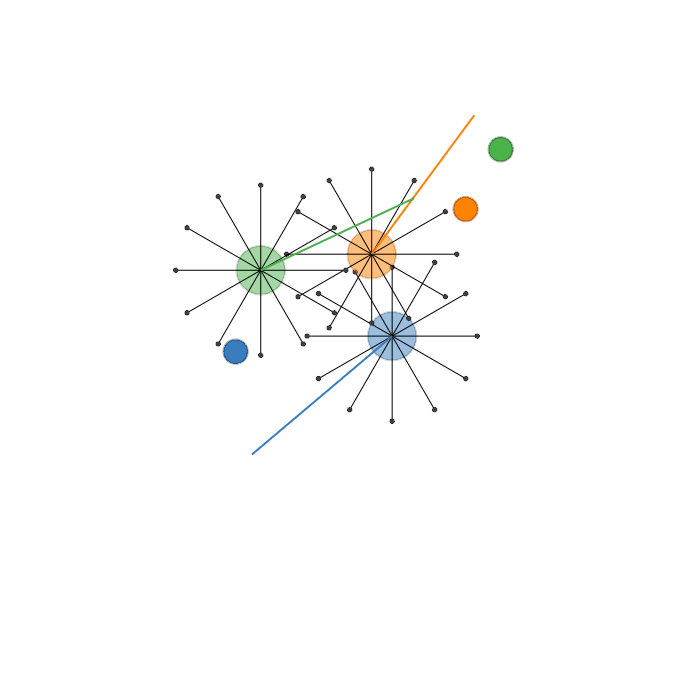

In [22]:
# Setup virtual display
virtual_display = setup_virtual_display()

# Render the final trained policy
if best_policy is not None and best_critic is not None:
    render_policy(best_env, best_policy, updated_hyperparams, device)
else:
    print("Best policy and critic could not be loaded. Rendering skipped.")